# ARCH, GARCHモデルを使って分散不均一性の説明を試みる

- ARCH: AutoRegressive Conditional Heteroscedasticity
    - ARモデルとは違い、誤差項の分散が時間依存（一時刻前の誤差の関数として）する
    - 誤差項の分散をボラティリティと呼ぶ。つまりボラティリティが過去の誤差の2乗に依存するモデル
- GARCH: Generalized ARCH
    - ボラティリティが過去の誤差の2乗と過去のボラティリティの2乗に依存するモデル

S&P500先物にARモデルを当てはめた後の残差（つまり誤差項）の2乗に時間依存があることがわかっているので、誤差項が過去の誤差の2乗に依存するモデルであるARCHやGARCHモデルを当てはめてみるのは自然な解決策と言える。

**結果については最下部のセルを参照。**

In [1]:
%matplotlib inline

import arch
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [8]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

<ipython-input-8-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
<ipython-input-8-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100


# 2019年の1年間のみのデータ

In [9]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

In [14]:
rrdfs2019[0]

,Close,logC,CloseDiff,logCDiff
datetime,,,,
2019-01-02 17:00:00,2513.75,7.829531,5.75,0.229004
2019-01-03 17:00:00,2450.50,7.804047,-63.25,-2.548358
2019-01-04 17:00:00,2534.00,7.837554,83.50,3.350700
2019-01-07 17:00:00,2553.25,7.845122,19.25,0.756798
2019-01-08 17:00:00,2575.25,7.853702,22.00,0.857956
...,...,...,...,...
2019-12-24 17:00:00,3214.50,8.075427,-1.50,-0.046653
2019-12-26 17:00:00,3233.25,8.081243,18.75,0.581600
2019-12-27 17:00:00,3226.25,8.079076,-7.00,-0.216735


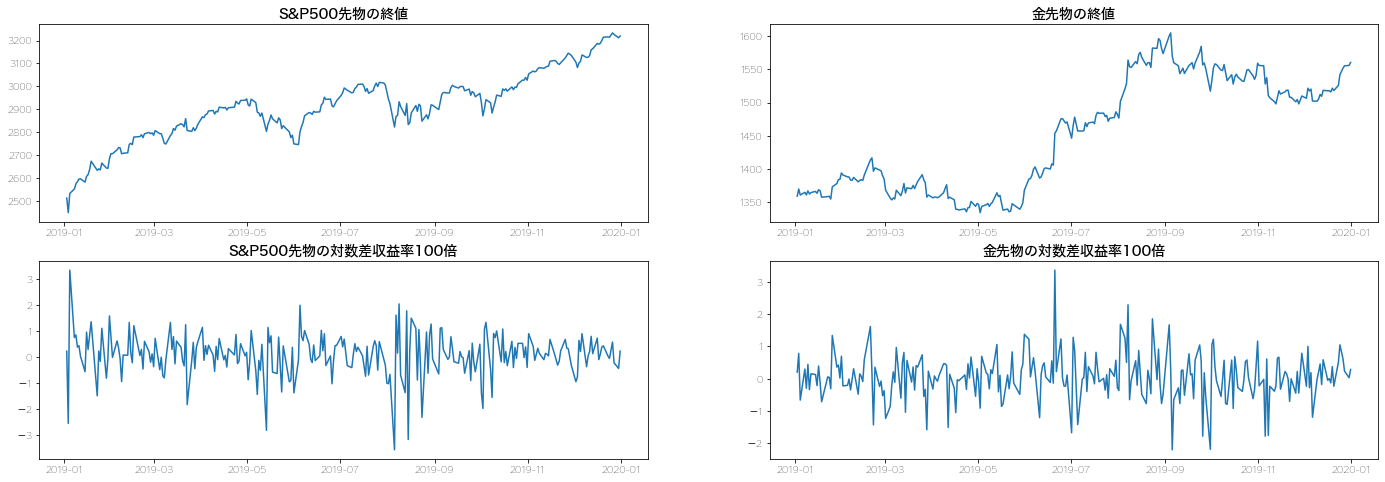

In [20]:
# 比較のため価格と対数差収益率を可視化しておく
fig, ax = plt.subplots(2, 2, figsize=(24,8))
for i, prod in enumerate(prods):
    ax[0,i].plot(rrdfs2019[i].index, rrdfs2019[i]['Close'])
    ax[0,i].set_title(f'{prod}の終値', fontsize=14, fontweight='semibold')
    ax[1,i].plot(rrdfs2019[i].index, rrdfs2019[i]['logCDiff'])
    ax[1,i].set_title(f'{prod}の対数差収益率100倍', fontsize=14, fontweight='semibold')

# GARCHモデルを当てはめてみる

S&P500先物については以前の分析で誤差が時間依存することが示されているため、GARCHモデルがARより妥当だと予想される。金先物については誤差をホワイトノイズをみなせるため、GARCHモデルよりARモデルが妥当だと予想される。

ARCH,GARCHはstatsmodelsではなく[archパッケージ](https://pypi.org/project/arch/)を使う。[公式ドキュメント](https://arch.readthedocs.io/en/latest/index.html)

In [41]:
"""
これまで「現場ですぐ使える時系列データ分析」に従って有意水準を10%としてきたが、
本によれば計量経済学では10%がよく用いられるとのことだったが少し調べてた限りでは
大学の経済学講義スライドなどをみても1%や5%と書いてあり、10%というのがよく用いら
れるということを支持する根拠が得られないため、今後はより一般的と思われる5%を用いる。

S&P500先物については、μ, ω, α, βの全ての推定値についてp < 0.05のため、ARCHモデル当てはめの信頼性は高い。
金先物については、β以外の3つのパラメータの推定値についてp >> 0.05のため、当てはめ信頼性は低い。

これらの結果は、以前の分析でS&Pの誤差は時間依存するが、金先物の誤差はホワイトノイズとみなせる、という結果とよく合う。
"""

garch_models = [arch.arch_model(df['logCDiff'], vol='GARCH') for df in rrdfs2019]
results = [am.fit() for am in garch_models]
[print(res.summary()) for res in results]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 280.1633424807529
Iteration:      2,   Func. Count:     15,   Neg. LLF: 279.7555156341797
Iteration:      3,   Func. Count:     22,   Neg. LLF: 278.85894233362023
Iteration:      4,   Func. Count:     29,   Neg. LLF: 278.5771982948273
Iteration:      5,   Func. Count:     36,   Neg. LLF: 278.50903476953
Iteration:      6,   Func. Count:     42,   Neg. LLF: 278.37235569054616
Iteration:      7,   Func. Count:     50,   Neg. LLF: 278.31061721120045
Iteration:      8,   Func. Count:     57,   Neg. LLF: 278.1723819101986
Iteration:      9,   Func. Count:     63,   Neg. LLF: 278.0931165367692
Iteration:     10,   Func. Count:     69,   Neg. LLF: 278.0664926912316
Iteration:     11,   Func. Count:     75,   Neg. LLF: 278.0654880090831
Iteration:     12,   Func. Count:     81,   Neg. LLF: 278.06545144193785
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 278.0654507557843
            Iterations: 1

[None, None]

# 標準化残差とボラティリティをプロットする

Text(0.5, 1.0, 'S&P500先物の条件付きボラティリティ')

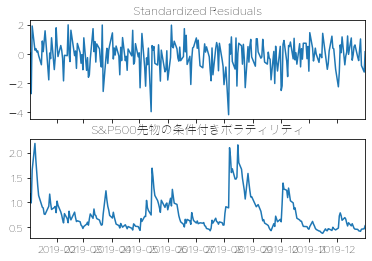

In [27]:
results[0].plot()
plt.title(f'S&P500先物の条件付きボラティリティ')

Text(0.5, 1.0, '金先物の条件付きボラティリティ')

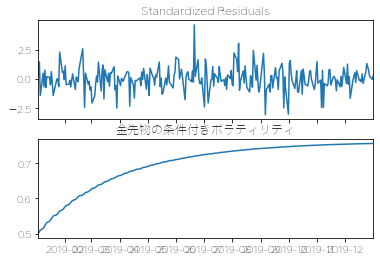

In [28]:
results[1].plot()
plt.title(f'金先物の条件付きボラティリティ')

# 標準化残差の性質を確認
モデルの定義からすれば標準正規分布に従うはず。モデル当てはめがうまくいっていれば、実際に従っているはず。
- 正規QQプロット
- Shapiro-Wilkの正規性検定

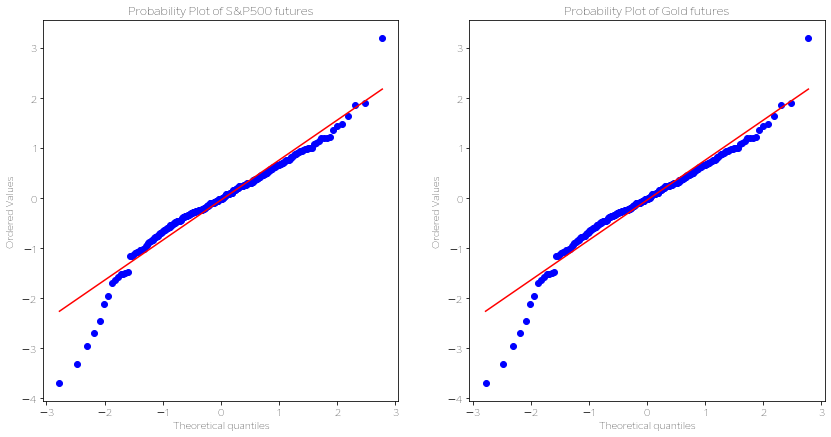

In [33]:
"""
S&P500先物も金先物も、平均から大きく離れると正規分布から外れていくようだ
正規性はないと言って良さそうだが、一応Shapiro-Wilkの正規性検定もやった方が良い。
"""
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
stats.probplot(results[0].resid, dist="norm", plot=ax[0])
stats.probplot(results[0].resid, dist="norm", plot=ax[1])
ax[0].set_title(f'Probability Plot of S&P500 futures')
ax[1].set_title(f'Probability Plot of Gold futures')
plt.show()

In [38]:
# Shapiro-Wilkの正規性検定
"""
帰無仮説は「正規分布に従っている」のため、検定を厳しくするためここでは有意水準を5%ではなく10%とする。
S&P先物については、p=2.55e-08 << 0.1 より正規分布に従うとは仮定できない
金先物についても、p=2.55e-08 << 0.1 より正規分布に従うとは仮定できない

これらの結果は、どちらのデータについてもGARCHモデル当てはめによってデータの分散（そしてS&P500の場合は分散不均一性）
をうまく説明できていないということを示唆する。
金先物についてはもともと誤差分散をホワイトノイズとみなせたためこの結果は以前の分析結果に合うものだが、
S&P500先物については、GARCHモデルのパラメータ推定の信頼性は高かったので、その結果とは合わない結果となった。
"""

W_sp, p_sp = stats.shapiro(results[0].resid)
print(f"S&P500先物のARCHモデルあてはめ残差についてのp値：{p_sp}")

W_gold, p_gold = stats.shapiro(results[0].resid)
print(f"金先物のARCHモデルあてはめ残差についてのp値：{p_gold}")

S&P500先物のARCHモデルあてはめ残差についてのp値：2.5594358632474723e-08
金先物のARCHモデルあてはめ残差についてのp値：2.5594358632474723e-08


# ARCHモデルの当てはめ

S&P500先物については以前の分析で誤差が時間依存することが示されているため、ARCHモデルがARより妥当だと予想される。金先物については誤差をホワイトノイズをみなせるため、ARCHモデルよりARモデルが妥当だと予想される。

In [44]:
"""
有意水準として5%を用いる。

S&P500先物については、μ, ωの推定値についてはp < 0.05だが、αについてはp=0.073 > 0.05のため当てはめ信頼度が高いとは言えない。
金先物については、ω以外の2つのパラメータの推定値についてp >> 0.05のため、当てはめ信頼性は低い。

以前の分析でS&PのARモデルあてはめ誤差は時間依存することが示されたが、ARCHモデルで誤差の時間依存をうまく説明できることは示されなかった。
金先物については、そのARモデルあてはめ誤差はホワイトノイズとみなせるという以前の結果と合う。
"""

arch_models = [arch.arch_model(df['logCDiff'], vol='ARCH') for df in rrdfs2019]
aresults = [am.fit() for am in arch_models]
[print(res.summary()) for res in results]

Iteration:      1,   Func. Count:      5,   Neg. LLF: 298.9495233625239
Iteration:      2,   Func. Count:     13,   Neg. LLF: 298.9307260688976
Iteration:      3,   Func. Count:     21,   Neg. LLF: 298.93068249306947
Iteration:      4,   Func. Count:     28,   Neg. LLF: 298.93066660614454
Iteration:      5,   Func. Count:     33,   Neg. LLF: 298.93065892211575
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 298.9306589221155
            Iterations: 5
            Function evaluations: 33
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 270.08537294070663
Iteration:      2,   Func. Count:     13,   Neg. LLF: 269.87670148533425
Iteration:      3,   Func. Count:     21,   Neg. LLF: 269.80231811152265
Iteration:      4,   Func. Count:     26,   Neg. LLF: 267.0306384400674
Iteration:      5,   Func. Count:     31,   Neg. LLF: 267.0232660954994
Iteration:      6,   Func. Count:     36,   Neg. LLF: 267.02314893

[None, None]

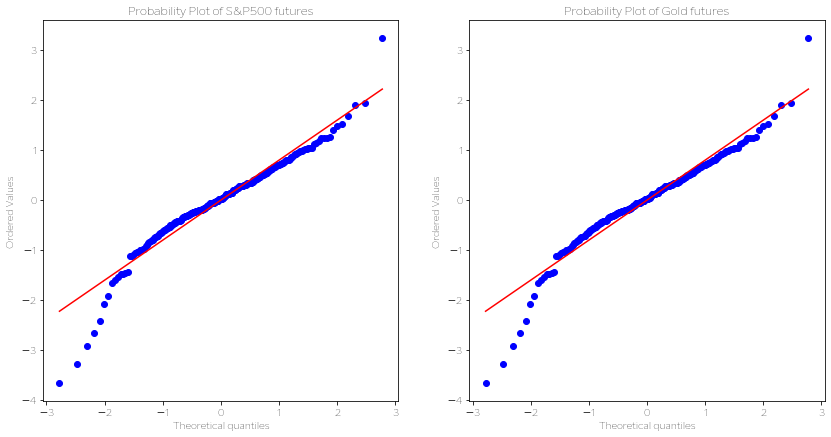

In [45]:
"""
S&P500先物も金先物も、平均から大きく離れると正規分布から外れていくようだ
正規性はないと言って良さそうだが、一応Shapiro-Wilkの正規性検定もやった方が良い。
"""
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
stats.probplot(aresults[0].resid, dist="norm", plot=ax[0])
stats.probplot(aresults[0].resid, dist="norm", plot=ax[1])
ax[0].set_title(f'Probability Plot of S&P500 futures')
ax[1].set_title(f'Probability Plot of Gold futures')
plt.show()

In [46]:
# Shapiro-Wilkの正規性検定
"""
帰無仮説は「正規分布に従っている」のため、検定を厳しくするためここでは有意水準を5%ではなく10%とする。
S&P先物については、p=2.55e-08 << 0.1 より正規分布に従うとは仮定できない
金先物についても、p=2.55e-08 << 0.1 より正規分布に従うとは仮定できない

これらの結果は、どちらのデータについてもARCHモデル当てはめによってデータの分散（そしてS&P500の場合は分散不均一性）
をうまく説明できていないということを示唆する。
金先物についてはもともと誤差分散をホワイトノイズとみなせたためこの結果は以前の分析結果に合うものだが、
S&P500先物については、ARCHモデルのパラメータ推定の信頼性は高かったので、その結果とは合わない結果となった。
"""

W_sp, p_sp = stats.shapiro(aresults[0].resid)
print(f"S&P500先物のARCHモデルあてはめ残差についてのp値：{p_sp}")

W_gold, p_gold = stats.shapiro(aresults[0].resid)
print(f"金先物のARCHモデルあてはめ残差についてのp値：{p_gold}")

S&P500先物のARCHモデルあてはめ残差についてのp値：2.559504430621473e-08
金先物のARCHモデルあてはめ残差についてのp値：2.559504430621473e-08


# まとめ

## GARCHの結果について
- S&P500先物についてはパラメータ推定のp値は0.05より小さかったためうまく説明できているようだったが、正規QQプロットでもShapiro-Wilk検定でも、標準化誤差が正規分布に従わないことが示唆されたため、実際にはあてはめはうまくいっていない可能性が高い。
- 金先物については、ARモデルあてはめの残差をホワイトノイズとみなせたためGARCHを適用する理由がそもそもないが、適用してみたらやはりあてはめ信頼性は低かった。

## ARCHの結果について
- S&P500先物については、GARCHの結果よりもパラメータ推定のp値が大きく、そもそもうまく説明できていないし、正規性検定でも標準化誤差が正規分布に従わないことが示唆された
- 金先物についてはGARCHの結果と同様の結論。

## 総まとめ

- S&P500先物についてはARCH/GARCHでもその誤差の時間依存を説明できなかったため、他の方法を検討する必要がある。
- 金先物については「ARモデルで説明できる」という以前の分析結果が補強された。

# S&P500先物データを説明する方法

GARCHモデルには、非正規な標準化誤差を持つものがあるため、それを試してみるのが良いだろう。